In [ ]:
import numpy as np 
import pandas as pd
from sklearn.linear_model import LogisticRegression,ElasticNet,Lasso
from sklearn.feature_selection import RFE
from numpy import where,unique
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score,mean_squared_error,r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
%matplotlib inline


### Import Dataset

In [ ]:
df_pretraite= pd.read_csv('C:\\Users\\actou\\OneDrive\\Documents\\IODAA\\AZOTE\\Classification\\data_pretraite_J5.csv',sep = ';')
df_pretraite.head()
df_pretraite.sort_values(by=["N20"],ascending = True)
#df_pretraite.isna().sum().describe()

df_svm = pd.read_csv('C:\\Users\\actou\\OneDrive\\Documents\\IODAA\\AZOTE\\Classification\\data_svm_result.csv',sep = ';')
df_svm.head()
df_svm.sort_values(by=["N20"],ascending = True)
#df_svm.isna().sum().describe()

df_stat = pd.read_csv('C:\\Users\\actou\\OneDrive\\Documents\\IODAA\\AZOTE\\Classification\\df_clean_pic_stat.csv',sep = ';')
df_stat.head()
df_stat.sort_values(by=["N20"],ascending = True)
#df_stat.isna().sum().describe()

#Liste des variables communes aux trois df
var_communes = set(df_pretraite.columns).intersection(set(df_stat.columns)).intersection(set(df_svm.columns))

#Liste des variables de proppre à chaque df
var_only_df_pretraite = set(df_pretraite.columns) - set(df_stat.columns) - set(df_svm.columns)
var_only_df_stat =  set(df_stat.columns) - set(df_pretraite.columns) - set(df_svm.columns)
var_only_df_svm = set(df_svm.columns) - set(df_pretraite.columns) - set(df_stat.columns)

print('Les variables propres à df_stat sont :',var_only_df_stat)
print('Les variables propres à df_svm sont :',var_only_df_svm)
print('Les variables propres à df_pretraite sont :',var_only_df_pretraite)

#Ajout des colonnes
df_pretraite["Pic_svm"] = df_svm["Pic"]
df_pretraite["Pic_stat"] = df_stat["Pic_stat"]
df_pretraite.info()

Le dataframe utilisé pour la suite de ce notebook est **df**

## NOUVEAU DATASET

In [80]:
df_pretraite= pd.read_csv('C:\\Users\\actou\\OneDrive\\Documents\\IODAA\\AZOTE\\data\\data_pretraite.csv',sep = ';')
df_pretraite.head()
df_pretraite.sort_values(by=["N20"],ascending = True)
df_pretraite= df_pretraite.drop(["Unnamed: 0"], axis=1)
df = df_pretraite

### Valeurs manquantes 

In [81]:
df.isna().sum().describe()

count     58.000000
mean     195.310345
std      189.937959
min        0.000000
25%        0.000000
50%      370.000000
75%      379.000000
max      379.000000
dtype: float64

In [24]:
def repartition_val_manquantes(df):
    df.isna().sum().to_csv('Données manquantes', index=False)
  
    ## Répartition des valeurs manquantes 
    val_NA_0 = len(df.columns[df.isna().sum() == 0].tolist())/len(df.columns)*100
    val_NA_0_25 = len(df.columns[df.isna().sum() > 0] & df.columns[df.isna().sum() < 372*0.25])/len(df.columns)*100 ## + de 25 
    val_NA_25_50 = len(df.columns[df.isna().sum() > 372*0.25 ] & df.columns[df.isna().sum() < 372*0.5])/len(df.columns)*100 ## + de 25 
    val_NA_50_75 = len(df.columns[df.isna().sum() > 372*0.5 ] & df.columns[df.isna().sum() < 372*0.75 ])/len(df.columns)*100 ## + de 25 
    val_NA_75_100 = len(df.columns[df.isna().sum() > 373*0.75].tolist())/len(df.columns)*100

    values = [val_NA_0, val_NA_0_25,val_NA_75_100]
    labels = ['0%',']0 - 25]%', ']75 - 100]%']
    
    plt.title("Répartition des valeurs manquantes par colonne")
    plt.pie(values, labels = labels, autopct='%1.1f%%', startangle=90)
    plt.show()
    #plt.savefig('missing_values_pie_chart.png')
   

On enlève les colonnes qui ont au moins une donnée manquantes 

In [30]:
def rmv_val_manquantes(df):
    df.replace(r'\s+', np.nan,regex = True)
    df= df.dropna(axis = 1)
    df.isna().sum().describe()
    df.info()

C:\Users\actou\AppData\Local\Temp\ipykernel_16048\1724639180.py:6: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  val_NA_0_25 = len(df.columns[df.isna().sum() > 0] & df.columns[df.isna().sum() < 372*0.25])/len(df.columns)*100 ## + de 25
C:\Users\actou\AppData\Local\Temp\ipykernel_16048\1724639180.py:7: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  val_NA_25_50 = len(df.columns[df.isna().sum() > 372*0.25 ] & df.columns[df.isna().sum() < 372*0.5])/len(df.columns)*100 ## + de 25
C:\Users\actou\AppData\Local\Temp\ipykernel_16048\1724639180.py:8: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(ot

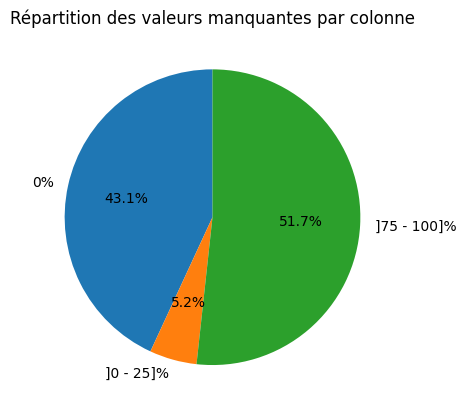

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   N20         379 non-null    float64
 1   Date        379 non-null    object 
 2   Bande       379 non-null    object 
 3   soilH_H1    379 non-null    float64
 4   soilH_H2    379 non-null    float64
 5   NO3_H1      379 non-null    float64
 6   NO3_H2      379 non-null    float64
 7   NH4_H1      379 non-null    float64
 8   NH4_H2      379 non-null    float64
 9   meanTP_J1   379 non-null    float64
 10  airH_J1     379 non-null    float64
 11  pluie_J1    379 non-null    float64
 12  meanTP_J2   379 non-null    float64
 13  airH_J2     379 non-null    float64
 14  pluie_J2    379 non-null    float64
 15  meanTP_J3   379 non-null    float64
 16  airH_J3     379 non-null    float64
 17  pluie_J3    379 non-null    float64
 18  meanTP_J4   379 non-null    float64
 19  airH_J4     379 non-null    f

In [82]:
repartition_val_manquantes(df)
rmv_val_manquantes(df)

## Correlation


In [62]:
def check_correlations(df,niv_corr):

    ''' 
        Corrélation entre les variables 
    '''
    corr = df.corr()
    liste_corr = corr.unstack().sort_values(ascending=False).reset_index()
    liste_corr = liste_corr[liste_corr.level_0 != liste_corr.level_1]
    liste_corr = liste_corr[liste_corr[0] > niv_corr]
    liste_corr = liste_corr.loc[:, ['level_0', 'level_1', 0]]
    liste_corr.columns = ['var1', 'var2', 'Niveau  de correlation']
    liste_corr

    '''
      HEATMAP
    '''
    plt.figure(figsize=(20,10))
    sns.heatmap(df.corr(),vmin=-1,vmax=1,center=0,annot=False)
    plt.title('Heatmap of Correlations')

    '''
        Nombre de paires corrélées par niveau de corrélation [0.6 - 1]
    ''' 
    niv_corr = [0.6,0.7,0.75,0.8,0.85,0.9,0.95,1]
    liste_nb_paires = []
    liste_corr = df.corr().unstack().sort_values(ascending=False).reset_index()
    liste_corr = liste_corr[liste_corr.level_0 != liste_corr.level_1]
    for i in niv_corr:
        liste_corr = liste_corr[liste_corr[0] > i]
        liste_nb_paires.append(len(liste_corr))

    pd.DataFrame({"Niveau de corrélation": niv_corr, 'Nombre de paires':liste_nb_paires})

    '''
        Liste des paires de variables avec un niveau de correlation : niv_corr
    '''
    
    corr[corr == niv_corr].stack().reset_index()
    pairs_corr = corr[corr > 0.8].stack().reset_index().drop_duplicates()
    pairs_corr.columns = ['var1','var2','corr']
    vars_corr = pairs_corr['var1'].unique().tolist() + pairs_corr['var2'].unique().tolist()
    vars_corr = list(set(vars_corr))
    print("La liste des paires de variables au niveau de corrélation ",niv_corr,"sont:",pairs_corr)

In [ ]:
check_correlations(df,1)

## Date 


In [84]:
df['mois'] = pd.DatetimeIndex(df['Date']).month
df['année'] = pd.DatetimeIndex(df['Date']).year
df['mois'] = df['mois'].astype('object')
df['année'] = df['année'].astype('object')

# Afficher le dataframe avec les nouvelles colonnes "mois" et "année"
df = df.drop(columns=['Date'])

## OneHotEncoding 

In [85]:
## Liste des varaibles qualitatives 
liste_var = list(df.select_dtypes(include=['object']).columns)
print("Les variables qualitatives sont:",liste_var)

Les variables qualitatives sont: ['Bande', 'mois', 'année']


In [96]:
def encodage(df,liste_variable_a_encoder):

    '''
        Le datset encodé est exporté dans le setwd
    ''' 
    liste_var = liste_variable_a_encoder
    encoder = OneHotEncoder(sparse=False)

    for column in liste_var:
        one_hot_encoded_df = pd.DataFrame(encoder.fit_transform(df[[column]]))
        one_hot_encoded_df.columns = encoder.get_feature_names([column])
        df= df.drop([column], axis=1).merge(one_hot_encoded_df, left_index=True, right_index=True)

    print("La liste des variables après l'encodage, est :",list(df.columns))
    df.to_csv('df_encoded.csv', index=True)
    df.info()

    return df 

In [ ]:
encodage(df,liste_var)

In [104]:
df= pd.read_csv('C:\\Users\\actou\\OneDrive\\Documents\\IODAA\\AZOTE\\Classification\\df_encoded.csv',sep = ',')
df.columns

Index(['Unnamed: 0', 'N20', 'soilH_H1', 'soilH_H2', 'NO3_H1', 'NO3_H2',
       'NH4_H1', 'NH4_H2', 'meanTP', 'airH', 'pluie', 'soilH_H1_J1',
       'soilH_H2_J1', 'NO3_H1_J1', 'NO3_H2_J1', 'NH4_H1_J1', 'NH4_H2_J1',
       'meanTP_J1', 'airH_J1', 'pluie_J1', 'soilH_H1_J2', 'soilH_H2_J2',
       'NO3_H1_J2', 'NO3_H2_J2', 'NH4_H1_J2', 'NH4_H2_J2', 'meanTP_J2',
       'airH_J2', 'pluie_J2', 'soilH_H1_J3', 'soilH_H2_J3', 'NO3_H1_J3',
       'NO3_H2_J3', 'NH4_H1_J3', 'NH4_H2_J3', 'meanTP_J3', 'airH_J3',
       'pluie_J3', 'soilH_H1_J4', 'soilH_H2_J4', 'NO3_H1_J4', 'NO3_H2_J4',
       'NH4_H1_J4', 'NH4_H2_J4', 'meanTP_J4', 'airH_J4', 'pluie_J4',
       'soilH_H1_J5', 'soilH_H2_J5', 'NO3_H1_J5', 'NO3_H2_J5', 'NH4_H1_J5',
       'NH4_H2_J5', 'meanTP_J5', 'airH_J5', 'pluie_J5', 'rolled_N20',
       'Bande_acs', 'Bande_bi', 'Bande_bio', 'Bande_elev', 'Bande_pn',
       'Bande_ref', 'mois_1', 'mois_2', 'mois_3', 'mois_4', 'mois_5', 'mois_6',
       'mois_7', 'mois_8', 'mois_9', 'mois_10', 'mois_11

### Nombre de pics 

In [103]:
def nombre_pics(df,nom_var_pic,nom_Pic_OUI):
    '''
        Compter le nombre de pics et de non-pics
    '''
    liste_un = len(np.where(df[nom_var_pic] == nom_Pic_OUI)[0].tolist())
    liste_zero = len(df[nom_var_pic] - liste_un)
    size_group = [liste_un,liste_zero]

    '''
        Tracer Pie Chart 
    ''' 
    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.pie(size_group,labels=("Pic","Pas_pic"),autopct='%1.1f%%',colors=['green','blue'])
    plt.title("Répartition Stat")
    my_circle=plt.Circle( (0,0), 0.7, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)

### Split dataset 

In [93]:
def normalisation_and_split(X,y,proportion_set_test):
    X =pd.DataFrame(X)
    y= pd.DataFrame(y)
    Min_Max = MinMaxScaler()
    X = Min_Max.fit_transform(X)
    y= Min_Max.fit_transform(y.values.reshape(-1,1))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=proportion_set_test,random_state=0)

    return X_train,X_test,y_train,y_test

### Tableau résultats selection de variables 

# Méthode de sélection (filter & Wrapper)

### LASSO

### Vérifier la condition d'ireprésentabilité

In [ ]:
def verif_condition_ireprésentabilite_METHODE1(X,y):
    model = sm.OLS(y, X) # Define the linear regression model
    ols_results = model.fit() # Estimate the OLS model
    coefs = ols_results.params # Assess the coefficients of the linear regression model
    strong_irrepresentability_code = np.mean(np.abs(coefs)) # Compute the strong irrepresentability code
    corr_matrix = np.corrcoef(X, rowvar=False) # Calculate the correlation matrix between the features
    avg_abs_corr = np.mean(np.abs(corr_matrix))  # Compute the average absolute correlation
    representability_condition = strong_irrepresentability_code + avg_abs_corr # Calculate the representability condition
    if representability_condition < 1: # Determine if the representability condition is satisfied
        print("The representability condition is satisfied.")
    else:
        print("The representability condition is not satisfied.")

In [ ]:
def verif_condition_ireprésentabilite_METHODE2(X):
    n_vars = X.shape[1]# Get the number of variables
    results = []# Create a list to store the results
    for i in range(n_vars):# Loop through each variable
        corr = np.corrcoef(X[:, i], X[:, -1])[0, 1]# Calculate the correlation between each variable and the target
        if corr != 0:# If the correlation is not 0, then the variable is not strongly irrepresentable
            results.append(False)
            print("The condition is not satisfied")
        else:
            results.append(True)  
    return results

In [53]:
def selection_variables_LASSO_RFC(X_train,X_test,y_test,y_train,penalty):
    ''' 
        Cette fonction permet de rélaiser une selection de varaibles avec la méthode LASSO et de prédire les cklasses des oics avec un RandomForestClassifieur
        Les résultats sont directement implémentés dans le teableau final 
    '''

    ''' 
        MEILLEUR PARAMETRE ALPHA
    ''' 
    alphas = [0.0005, 0.001, 0.01, 0.03, 0.05, 0.1,0.5,1,5,10]
    liste_score,liste_alpha =  [],[]
    
    for a in alphas:
        model = Lasso(alpha=a)
        model.fit(X_train, y_train)
        liste_score.append(model.score(X, y))
        liste_alpha.append(a)
        data = pd.DataFrame({"Alpha":liste_alpha,"R2":liste_score})
        max_r2 = data["R2"].idxmax()
        max_alpha = data.at[max_r2, 'colonne 2']
   

    '''
        Selection variables avec LASSO regularisée 
    '''
    model_lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
    model_lasso .fit(X_train, np.ravel(y_train,order='C'))
    model_lasso .get_support()
    X_train = pd.DataFrame(X_train)

    ## Variables selectionnées 
    variables_select= X_train.columns[(model_lasso .get_support())]
    
    ### Liste des variables conservées
    X_train_selected = model.transform(X_train)
    X_test_selected = model.transform(X_test)
    X_train_selected.shape, X_test_selected.shape

    ### Liste des variables supprimées
    variables_suppr= X_train.columns[(model.estimator_.coef_ == 0).ravel().tolist()]

    '''
         SANS RandomForest pour prédire les résultats 
    ''' 
    y_pred_sans_RFC = model_lasso.predict(X_test)
    resultats_selection_var = resultats_selection_var.append({'Méthode': penalty, 'RFC':'NON', 'Pic': ' / ', 'Nombre total de variables': '/ ', 'Nombre var selectionnnées': '/', 'Nombre de varaiables supprimées': 'x', 'Accuracy': accuracy_score(y_test,  y_pred_sans_RFC ), 'MSE': mean_squared_error(y_test,  y_pred_sans_RFC ), 'R2score': r2_score(y_test,  y_pred_sans_RFC )}, ignore_index=True)

    ''' 
        AVEC Random Forest pour prédire les résultats
    ''' 
    clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
    clf.fit(X_train_selected,np.ravel(y_train,order='C'))
    y_pred= clf.predict(X_test_selected)
    
    resultats_selection_var = resultats_selection_var.append({'Méthode': penalty,'RFC':'OUI', 'Pic': ' / ', 'Nombre total de variables': '/ ', 'Nombre var selectionnnées': '/', 'Nombre de varaiables supprimées': 'x', 'Accuracy': accuracy_score(y_test, y_pred), 'MSE': mean_squared_error(y_test, y_pred), 'R2score': r2_score(y_test, y_pred)}, ignore_index=True)

### ELASTIC NET 

In [99]:
def selection_variables_ELASTICNET_RFC(X_train,X_test,y_test,y_train,penalty):
    ''' 
        MEILLEUR PARAMETRE ALPHA & L1 ratio 
    ''' 
    alphas = [0.0005, 0.001, 0.01, 0.03, 0.05, 0.1,0.5]
    l1_ratios = [1, 0.9, 0.8, 0.7, 0.5,0.4,0.3,0.2,0.1]
    liste_score,liste_alpha,liste_L1= [],[],[]

    for alpha in alphas:
        for l1_ratio in l1_ratios:
            elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
            elastic_net.fit(X_train, y_train)
            liste_score.append(elastic_net.score(X_test, y_test))
            liste_alpha.append(alpha)
            liste_L1.append(l1_ratio)
            data = pd.DataFrame({"Alpha":liste_alpha,"L1_ratio":l1_ratio,"R2":liste_score}) 
            max_r2 = data["R2"].idxmax()
            max_alpha = data.at[max_r2, 'Alpha']
            max_l1ratio = data.at[max_r2, 'L1_ratio']


# Selection variables avec ELASTICNET
    '''
        Selection variables avec ELASTIC
    '''
    model_lasso = SelectFromModel(LogisticRegression(C=1, penalty='elasticnet',l1_ratio=max_l1ratio))
    model_lasso .fit(X_train, np.ravel(y_train,order='C'))
    model_lasso .get_support()
    X_train = pd.DataFrame(X_train)

    ## Variables selectionnées 
    variables_select= X_train.columns[(model_lasso .get_support())]
    
    ### Liste des variables conservées
    X_train_selected = model.transform(X_train)
    X_test_selected = model.transform(X_test)
    X_train_selected.shape, X_test_selected.shape

    ### Liste des variables supprimées
    variables_suppr= X_train.columns[(model.estimator_.coef_ == 0).ravel().tolist()]

    '''
         SANS RandomForest pour prédire les résultats 
    ''' 
    y_pred_sans_RFC = model_lasso.predict(X_test)
    resultats_selection_var = resultats_selection_var.append({'Méthode': penalty,'RFC': 'NON','Pic': ' / ', 'Nombre total de variables': '/ ', 'Nombre var selectionnnées': '/', 'Nombre de varaiables supprimées': 'x', 'Accuracy': accuracy_score(y_test,  y_pred_sans_RFC ), 'MSE': mean_squared_error(y_test,  y_pred_sans_RFC ), 'R2score': r2_score(y_test,  y_pred_sans_RFC )}, ignore_index=True)

    ''' 
        AVEC Random Forest pour prédire les résultats
    ''' 
    clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
    clf.fit(X_train_selected,np.ravel(y_train,order='C'))
    y_pred= clf.predict(X_test_selected)
    
    resultats_selection_var = resultats_selection_var.append({'Méthode': penalty,'RFC': 'OUI', 'Pic': ' / ', 'Nombre total de variables': '/ ', 'Nombre var selectionnnées': '/', 'Nombre de varaiables supprimées': 'x', 'Accuracy': accuracy_score(y_test, y_pred), 'MSE': mean_squared_error(y_test, y_pred), 'R2score': r2_score(y_test, y_pred)}, ignore_index=True)

# Regression logistique + RFE 

In [50]:
def log_regression_rfe(X_train,X_test,y_test,y_train,nb_var):

    '''
        Cette fonction renvoie 
        - Les performances de la regression logistique dans la prédiction 
        - Les n variables qui composent le modèle 

    '''

    '''
        Modèle
    '''
    lr= LogisticRegression()
    Nb_var_selected = 10 
    rfe = RFE(lr, n_features_to_select = nb_var,step=1)
    rfe = rfe.fit(X_train, y_train)
    y_pred = rfe.predict(X_test)

    '''
        Performances
    '''
    resultats_LOG_REG_RFE= pd.DataFrame({"Measure": ["Accuracy", "Mean Squared Error","R2 Score"],"Reg_LOGISTIQUE + RFE - STAT": [accuracy_score(y_test, y_pred),mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)]})
    resultats_LOG_REG_RFE.round(2)

    '''
        Variables selectionnées   
    '''
    RFE_result =  pd.DataFrame({"Variables":pd.DataFrame(df).columns,"RFE ranking":rfe.ranking_.tolist()})
    RFE_result.sort_values(by=["RFE ranking"],ascending = True)
    RFE_result[RFE_result["RFE ranking"] == 1]

_________________________________________


# BBRRROOUUIILLOONN  

lasso

In [ ]:
''' 

# Selection variables avec LASSO
model = Lasso(alpha = 0.0005)
model.fit(X_train_SVM, np.ravel(y_train_SVM,order='C'))
y_pred_sans = model.predict(X_test_SVM)

# Get the name of the selected variables
X_train_SVM = pd.DataFrame(X_train_SVM)
X_test_SVM = pd.DataFrame(X_test_SVM)
selected_vars = X_train_SVM.columns[(model.coef_ != 0).ravel().tolist()]

# Predict the performance of the classification on the y_test
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
clf.fit(X_train_stat[selected_vars],(pd.DataFrame(y_train_stat)).values.ravel())
y_pred = clf.predict(X_test_SVM[selected_vars])

'''

In [ ]:
''' 
alphas = [0.0005, 0.001, 0.01, 0.03, 0.05, 0.1,0.5]
l1_ratios = [1, 0.9, 0.8, 0.7, 0.5,0.4,0.3,0.2,0.1]
liste_score,liste_alpha,liste_L1, liste_L2= [],[],[],[]

for alpha in alphas:
  for l1_ratio in l1_ratios:
      elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
      elastic_net.fit(X_train_stat, y_train_stat)
      liste_score.append(elastic_net.score(X_test_stat, y_test_stat))
      liste_alpha.append(alpha)
      liste_L1.append(l1_ratio)
      liste_L2.append(l2_ratio)

pd.DataFrame({"Alpha":liste_alpha,"L1_ratio":l1_ratio,"R2":liste_score})

# Selection variables avec ELASTICNET
model = ElasticNet(alpha=0.0005, l1_ratio=0.1)
model.fit(X_train_stat, np.ravel(y_train_stat,order='C'))
y_pred_sans_stat = model.predict(X_test_stat)

# Get the name of the selected variables
X_train_stat = pd.DataFrame(X_train_stat)
X_test_stat = pd.DataFrame(X_test_stat)
selected_vars = X_train_stat.columns[(model.coef_ != 0).ravel().tolist()]

# Predict the performance of the classification on the y_test
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
clf.fit(X_train_stat[selected_vars],np.ravel(y_train_stat,order='C'))
y_pred_stat = clf.predict(X_test_stat[selected_vars])

'''

# Comparaison des résultats

### Liste de variables selectionnées avec LASSO communes aux deux types de pic

In [ ]:
liste_commune_variables_LASSO = []
var_ITK, var_meteo, var_Ntraj = 0,0,0

# ouvrir et récupérer les colonnes des fichiers
df_ITK = pd.read_excel('ITK_TrajectOire.xlsx')
df_meteo = pd.read_excel('meteo_2017_2022.xlsx')
df_Ntraj= pd.read_excel('Data_Ntraj.xlsx')

for i in liste_col_LASSO_selectionnees_STAT:
    if i in liste_col_selectionnees_SVM:
        liste_commune_variables_LASSO.append(i)

print(len(liste_commune_variables_LASSO))

for i in liste_commune_variables_LASSO:
    if i in list(df_meteo.columns):
	    var_meteo +=1
    if i in list(df_Ntraj.columns):
	    var_Ntraj +=1 

var_ITK = len(liste_commune_variables_LASSO) -  var_meteo - var_Ntraj

## Graph 
labels = ['ITK', 'Météo', 'Ntraj']
sizes = [var_ITK, var_meteo, var_Ntraj]
colors = ['red', 'green', 'yellow']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.legend(labels, loc="best")
plt.axis('equal')
plt.title("Répartition des variables")
plt.show()


### Liste de variables selectionnées avec ELASTIC_NET communes aux deux types de pic

In [ ]:
liste_commune_variables_EN = []
var_ITK, var_meteo, var_Ntraj = 0,0,0

for i in liste_col_ELASTICNET_STAT:
    if i in liste_col_ELASTICNET_SVM:
        liste_commune_variables_EN.append(i)

for i in liste_commune_variables_EN:
    if i in list(df_meteo.columns):
	    var_meteo +=1
    if i in list(df_Ntraj.columns):
	    var_Ntraj +=1 

var_ITK = len(liste_commune_variables_EN) -  var_meteo - var_Ntraj

## Graph 
labels = ['ITK', 'Météo', 'Ntraj']
sizes = [var_ITK, var_meteo, var_Ntraj]
colors = ['red', 'green', 'yellow']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.legend(labels, loc="best")
plt.axis('equal')
plt.title("Répartition des variables")
plt.show()


In [ ]:
### STAT 
liste_commune_variables_PIC_STAT = []

for i in liste_col_LASSO_selectionnees_STAT:
    if i in RFE_result_stat["Variables STAT"]:
        liste_commune_variables_PIC_STAT.append(i)

print(len(liste_commune_variables_PIC_STAT))

### SVM 
liste_commune_variables_PIC_SVM= []

for i in liste_col_selectionnees_SVM:
    if i in RFE_result_svm["Variables SVM"]:
        liste_commune_variables_PIC_SVM.append(i)

print(len(liste_commune_variables_PIC_SVM))
